In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data=pd.read_csv('/content/Processed_data.csv')

In [ ]:
data.head()

,Unnamed: 0,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Visibility(mi),Wind_Direction,Wind_Speed(mph),Weather_Condition,...,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99
0,0,3,0.000,72.0,72.000000,26.0,10.0,6,10.0,16,...,0.011294,-0.023450,0.009454,-0.007929,0.000032,-0.007039,-0.011485,0.015448,-0.012006,-0.003866
1,1,4,1.002,91.8,54.472104,48.0,10.0,22,18.4,6,...,0.039491,0.021280,-0.005106,-0.015760,0.016425,0.039872,-0.047719,-0.000016,-0.013681,-0.010934
2,2,1,0.000,91.0,91.000000,38.0,10.0,20,7.0,16,...,0.012038,0.099881,0.019001,0.063796,0.002496,0.006196,0.051213,-0.014346,-0.050256,-0.007663
3,3,4,1.500,77.0,77.000000,40.0,10.0,10,12.0,91,...,0.008458,-0.063279,-0.003959,-0.030436,-0.020446,-0.017096,-0.009632,0.055119,0.063940,0.017744
4,4,4,0.180,73.0,54.472104,26.0,10.0,10,15.0,91,...,-0.047187,0.015230,0.064401,0.005247,-0.016908,-0.042391,0.024430,-0.047003,0.015520,0.032127


In [4]:
data=data.drop(columns=['Unnamed: 0'])

In [5]:
data.shape

(256574, 127)

In [6]:
data.size

32584898

# Bagging Classifier

Import required libraries

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix, roc_auc_score,roc_curve

### Set Feature and Target columns

In [8]:
X=data.drop(columns=['Severity'])
y=data['Severity']

Split data into training and testing data

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

DecisionTree as base estimator
* Best settings for large dataset:
* DecisionTree as base estimator (high variance → bagging works best)
* n_estimators = 200 for stability
* bootstrap=True by default (bagging)
* max_samples=0.8 → each tree sees 80% of data
* max_features=1.0 → use all features
* n_jobs = -1 → use all CPU cores

In [10]:
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1
    ),
    n_estimators=200,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)


In [11]:
bag.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.8,
                  n_estimators=200, n_jobs=-1, random_state=42)

### Evaluation of model

In [12]:
bag_pred=bag.predict(X_test)
train_bag_pred=bag.predict(X_train)

In [14]:
print("Accuracy Score on train data :",accuracy_score(y_train,train_bag_pred))
print("Accuracy Score on test data :",accuracy_score(y_test,bag_pred))

Accuracy Score on train data : 0.9993617819437881
Accuracy Score on test data : 0.9065770242619117


### CLASSIFICATION REPORT (Precision, Recall, F1 per class)

In [15]:
bag_report=classification_report(y_test,bag_pred)
print(bag_report)

              precision    recall  f1-score   support

           1       0.93      0.95      0.94     12317
           2       0.87      0.86      0.87     13008
           3       0.88      0.88      0.88     13105
           4       0.94      0.93      0.94     12885

    accuracy                           0.91     51315
   macro avg       0.91      0.91      0.91     51315
weighted avg       0.91      0.91      0.91     51315



In [16]:
bag_pred_prob=bag.predict_proba(X_test)

### Macro & Weighed Multi-Class AUC (OVR)

1.   `List item`
2.   List item



In [17]:
macro_auc = roc_auc_score(y_test, bag_pred_prob, multi_class='ovr', average='macro')
weighted_auc = roc_auc_score(y_test, bag_pred_prob, multi_class='ovr', average='weighted')

print("Macro AUC     :", macro_auc)
print("Weighted AUC  :", weighted_auc)

Macro AUC     : 0.9856449262584217
Weighted AUC  : 0.9855148348046784


#### ROC CURVE FOR EACH CLASS

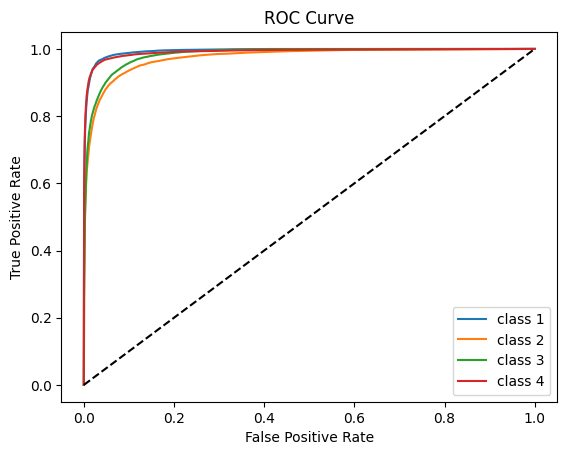

In [18]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
for i in range(len(classes)):
  fpr,tpr,_= roc_curve(y_test_bin[:,i],bag_pred_prob[:,i])
  plt.plot(fpr,tpr,label=f"class {classes[i]}")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Confusion matrix

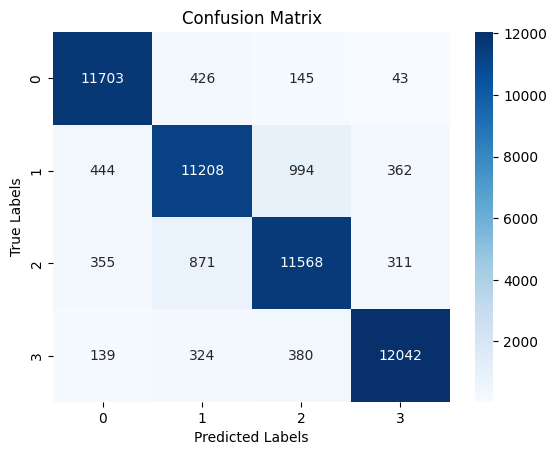

In [19]:
bag_cm=confusion_matrix(y_test,bag_pred)
sns.heatmap(bag_cm,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()